<a href="https://colab.research.google.com/github/primods/NN_Hepatitis/blob/main/NN_Hepatitis_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libs for Create a Neural Network and Data Manipulation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#setting theme for seaborn/matplotlib plots
sns.set()
sns.set_palette('hls')

In [2]:
#Creating Dataframe from csv data and cleaning

hep_data = pd.read_csv("HepatitisCdata.csv").drop("Unnamed: 0", axis=1)
y_data = hep_data["Category"]
X_data = pd.get_dummies(hep_data.drop("Category", axis=1))

hep_data = X_data.join(y_data)

#Categorical data to numerical, dropping suspect donors (only 7 entries) and NA values
hep_data = hep_data[hep_data["Category"] != "0s=suspect Blood Donor"].reset_index().drop("index", axis=1)
hep_data = hep_data.replace(list(hep_data["Category"].unique()),np.linspace(1,4,4))

hep_data.dropna(inplace=True)


#Replace values to make the a Binary Classification problem
hep_data["Category"] = hep_data["Category"].replace([2.0,3.0,4.0],2.0)


In [3]:
#Option to create a balanced data set

dis_df = hep_data[hep_data["Category"]==2.0]

#heal_df = hep_data[hep_data["Category"]==1.0].sample(len(dis_df)*2)
heal_df = hep_data[hep_data["Category"]==1.0]

hep_data = pd.concat([dis_df,heal_df])

In [4]:
#Splitting in X, y datasets and train, test sets

X_values = hep_data.drop(["Category","Sex_f","Sex_m"], axis=1).values
y_values = pd.get_dummies(hep_data["Category"].values).values
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values,
                                                    test_size=0.3, random_state=60,
                                                    stratify=y_values)

#Normalize the data

X_train = Normalizer().fit_transform(X_train)
X_test = Normalizer().transform(X_test)

In [5]:
#Create the neural network model

model = keras.Sequential(
    [keras.Input(shape=11),
     layers.Dense(8, activation="relu"),
     layers.Dense(6, activation="relu"),
     layers.Dense(2, activation="sigmoid")
    ])

In [6]:
#Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
 dense_2 (Dense)             (None, 2)                 14        
                                                                 
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________


In [7]:
#train and fit the model witch batch size of 10 and 100 epochs

batch_size = 10
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
33/33 [==============================] - 2s 26ms/step - loss: 0.7238 - accuracy: 0.2862 - val_loss: 0.6708 - val_accuracy: 0.8659
Epoch 2/100
33/33 [==============================] - 1s 23ms/step - loss: 0.6329 - accuracy: 0.9200 - val_loss: 0.6068 - val_accuracy: 0.8780
Epoch 3/100
33/33 [==============================] - 0s 15ms/step - loss: 0.5691 - accuracy: 0.9138 - val_loss: 0.5506 - val_accuracy: 0.8780
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.5081 - accuracy: 0.9108 - val_loss: 0.4943 - val_accuracy: 0.8780
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.4448 - accuracy: 0.9108 - val_loss: 0.4404 - val_accuracy: 0.8780
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.3855 - accuracy: 0.9108 - val_loss: 0.3976 - val_accuracy: 0.8780
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 0.3429 - accuracy: 0.9108 - val_loss: 0.3713 - val_accuracy: 0.8780
Epoch 8/10

In [8]:
#Function to make predictions 1 or 0 by probs
def binary_predictions(deepmodel, array_features):
  prob_array = np.round(deepmodel.predict(array_features),2)
  list_pred = []
  for i in prob_array:
    if i[0] > i[1]:
      list_pred.append(0)
    else:
      list_pred.append(1)
  return list_pred

In [9]:
#Predictions for the Test set
y_pred = binary_predictions(model, X_test)
#Make the y_test set unidimensional and binary again
y_test_original = pd.DataFrame(y_test).idxmax(axis=1)

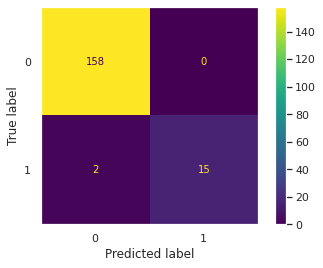

In [10]:
#Confussion matrix for test set
cm_hep = confusion_matrix(y_test_original, y_pred)
ConfusionMatrixDisplay(cm_hep).plot()
plt.grid(b=None)

In [11]:
#Classification report for test set data

print(classification_report(y_test_original, y_pred, target_names=["Healthy","Disease"]))

#>=.90 scores using all numerical features in f1-scores for all the classes

              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       158
     Disease       1.00      0.88      0.94        17

    accuracy                           0.99       175
   macro avg       0.99      0.94      0.97       175
weighted avg       0.99      0.99      0.99       175

